In [1]:
# Load all the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
from retry_requests import retry
import os
import time
import random
import seaborn as sns

### Call the API, fetch the required data and create the dataframe

In [2]:
# create a data directory called Data for our data
os.makedirs("Data", exist_ok=True)
print(f"Folder Data created successfully!")

Folder Data created successfully!


In [3]:
# Declare the latitude and longitude for both cities
cities = {"Zurich": {'loc': ["47.3769", "8.5417"]},
		  "Seattle": {'loc': ["47.6062", "122.3321"]}}

In [4]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [5]:
def call_API(city, openmeteo, cities):
    # Set the API call parameters
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
       "latitude": cities[city]['loc'][0],
       "longitude": cities[city]['loc'][1],
       "start_date": "1940-01-01",
       "end_date": "2024-12-31",
       "daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"],
       "timezone": cities[city].get('timezone', "Europe/Berlin") 
    }
    responses = openmeteo.weather_api(url, params=params)
    
    # Print the first part of the API response to validate the call data is valid
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
    
    return response

In the create_dataframe function we validate the data types as we receive the data, we also change the date format into a readable format and into a format that useful for our project as we don't need anything but the date. This save us from performing these tasks later on when we clean our data.

In [6]:
def create_dataframe(response):
	# Process data and validate variable types
	daily = response.Daily()
	daily_weather_code = daily.Variables(0).ValuesAsNumpy()
	daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
	daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
	daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
	daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
	daily_apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
	daily_apparent_temperature_mean = daily.Variables(6).ValuesAsNumpy()
	daily_sunrise = daily.Variables(7).ValuesAsNumpy()
	daily_sunset = daily.Variables(8).ValuesAsNumpy()
	daily_daylight_duration = daily.Variables(9).ValuesAsNumpy()
	daily_sunshine_duration = daily.Variables(10).ValuesAsNumpy()
	daily_precipitation_sum = daily.Variables(11).ValuesAsNumpy()
	daily_rain_sum = daily.Variables(12).ValuesAsNumpy()
	daily_snowfall_sum = daily.Variables(13).ValuesAsNumpy()
	daily_precipitation_hours = daily.Variables(14).ValuesAsNumpy()
	daily_wind_speed_10m_max = daily.Variables(15).ValuesAsNumpy()
	daily_wind_gusts_10m_max = daily.Variables(16).ValuesAsNumpy()
	daily_wind_direction_10m_dominant = daily.Variables(17).ValuesAsNumpy()
	daily_shortwave_radiation_sum = daily.Variables(18).ValuesAsNumpy()
	daily_et0_fao_evapotranspiration = daily.Variables(19).ValuesAsNumpy()
	
	# Format the date variable to readable format
	daily_data = {"date": pd.date_range(
		start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
		end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = daily.Interval()),
		inclusive = "left"
		).strftime('%Y/%m/%d')
	}
	
	# Create the pandas dataframe
	daily_data["weather_code"] = daily_weather_code
	daily_data["temperature_2m_max"] = daily_temperature_2m_max
	daily_data["temperature_2m_min"] = daily_temperature_2m_min
	daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
	daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
	daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
	daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
	daily_data["sunrise"] = daily_sunrise
	daily_data["sunset"] = daily_sunset
	daily_data["daylight_duration"] = daily_daylight_duration
	daily_data["sunshine_duration"] = daily_sunshine_duration
	daily_data["precipitation_sum"] = daily_precipitation_sum
	daily_data["rain_sum"] = daily_rain_sum
	daily_data["snowfall_sum"] = daily_snowfall_sum
	daily_data["precipitation_hours"] = daily_precipitation_hours
	daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
	daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
	daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
	daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum
	daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration
	
	# Make a dataframe from the dictionary
	daily_dataframe = pd.DataFrame(data = daily_data)
	
	return daily_dataframe

In [7]:
def save_df(data, city):
	# Save the dataframe as csv file
	data.to_csv(f"Data/{city}.csv", index = False)
	print(f"Saved data for '{city}' successfully!")

In [8]:
def combine_dataframes():
	# Create a single dataframe from the 2 datasets
	# Load the 2 datasets
	df1 = pd.read_csv("Data/Zurich.csv")
	df2 = pd.read_csv("Data/Seattle.csv")
	
	# Add a column to contains the city name
	df1['city'] = 'Zurich'
	df2['city'] = 'Seattle'
	
	# Concatenate the 2 dataframes
	start_df = pd.concat([df1, df2], ignore_index=True)
	
	# Write combined dataframes to csv file
	start_df.to_csv("Data/start.csv", index = False)

In [9]:
# Call the API and save the as csv files
# Saving as csv files to limit the amount of calls to data provider
count = 0
for city in cities:
	response = call_API(city, openmeteo, cities)
	data = create_dataframe(response)
	save_df(data, city)
	print('\n')

	# Delay the 2nd API call for 2 minutes to not violate limits on API calls
	if count < 1:
		time.sleep(120)
	count += 1

Coordinates 47.34621810913086°N 8.54337215423584°E
Elevation 409.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to GMT+0 3600 s
Saved data for 'Zurich' successfully!


Coordinates 47.62741470336914°N 122.17462158203125°E
Elevation 577.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to GMT+0 3600 s
Saved data for 'Seattle' successfully!




In [10]:
# Create a single dataframe from the 2 datasets
# Load the 2 datasets
df1 = pd.read_csv("Data/Zurich.csv")
df2 = pd.read_csv("Data/Seattle.csv")

# Add a column to contains the city name
df1['city'] = 'Zurich'
df2['city'] = 'Seattle'

# Concatenate the 2 dataframes
df = pd.concat([df1, df2], ignore_index=True)

In [ ]:
# Write combined dataframes to csv file
start_df.to_csv("Data/start.csv", index = False)

In [11]:
# Delete files no longer required
os.remove("Data/Seattle.csv")
os.remove("Data/Zurich.csv")

### Clean the dataset
Some of the data cleaning was preformed when we received the data from the API calls as it was deemed a more effiecent.

In [12]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [13]:
# Check for empty or all zeros columns
empty_cols = []
for col in numerical_cols:
	if df[col].sum() == 0:
		empty_cols.append(col)
		
print(empty_cols)

['sunrise', 'sunset']


In [14]:
# Remove two columns with only zero values
df = df.drop(empty_cols, axis=1)

In [15]:
# Get index of rows with NaN values
nan_rows = df[df.isna().any(axis=1)].index.tolist()

print(nan_rows)

[0, 31047]


In [16]:
df = df.drop(index=nan_rows, axis=0)

In [17]:
# See if the column is the correct data type
set(df.weather_code.unique())

{np.float64(0.0),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(51.0),
 np.float64(53.0),
 np.float64(55.0),
 np.float64(61.0),
 np.float64(63.0),
 np.float64(65.0),
 np.float64(71.0),
 np.float64(73.0),
 np.float64(75.0)}

In [18]:
df['weather_code'] = df['weather_code'].astype(int)

In [19]:
# Write cleaned dataframe to csv file to limit API calls
df.to_csv("Data/clean.csv", index = False)

### Check the dataset for outliers

In [20]:
# Identify remaining numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [21]:
# Find outliers for each column
outlier_results = []

# Calculate quartiles
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = len(outliers)
    
    # Only inspect 
    if num_outliers > 0:
        outlier_results.append({
            'Column': col,
            'Outliers Count': num_outliers,
            'Min': df[col].min(),
            'Q1': Q1,
            'Median': df[col].median(),
            'Q3': Q3,
            'Max': df[col].max(),
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound
        })

# Create DataFrame with outlier results
outlier_df = pd.DataFrame(outlier_results)
print("\nOutlier Summary:")
print(outlier_df)


Outlier Summary:
                        Column  Outliers Count        Min         Q1  \
0           temperature_2m_max             102 -28.598500   2.992000   
1           temperature_2m_min             712 -35.448500  -4.498500   
2          temperature_2m_mean             308 -33.081833  -0.766167   
3     apparent_temperature_max              26 -35.357895  -1.083051   
4     apparent_temperature_min             159 -41.875416  -8.925577   
5    apparent_temperature_mean              49 -39.444570  -5.041681   
6            precipitation_sum            8764   0.000000   0.000000   
7                     rain_sum           10047   0.000000   0.000000   
8                 snowfall_sum            7749   0.000000   0.000000   
9          precipitation_hours            4474   0.000000   0.000000   
10          wind_speed_10m_max             885   1.609969   9.178235   
11          wind_gusts_10m_max             954   7.559999  23.039999   
12  et0_fao_evapotranspiration              56

In [22]:
# Get the variables that have the most outliers
outlier_col = list(outlier_df[outlier_df['Outliers Count'] > 1000].Column)

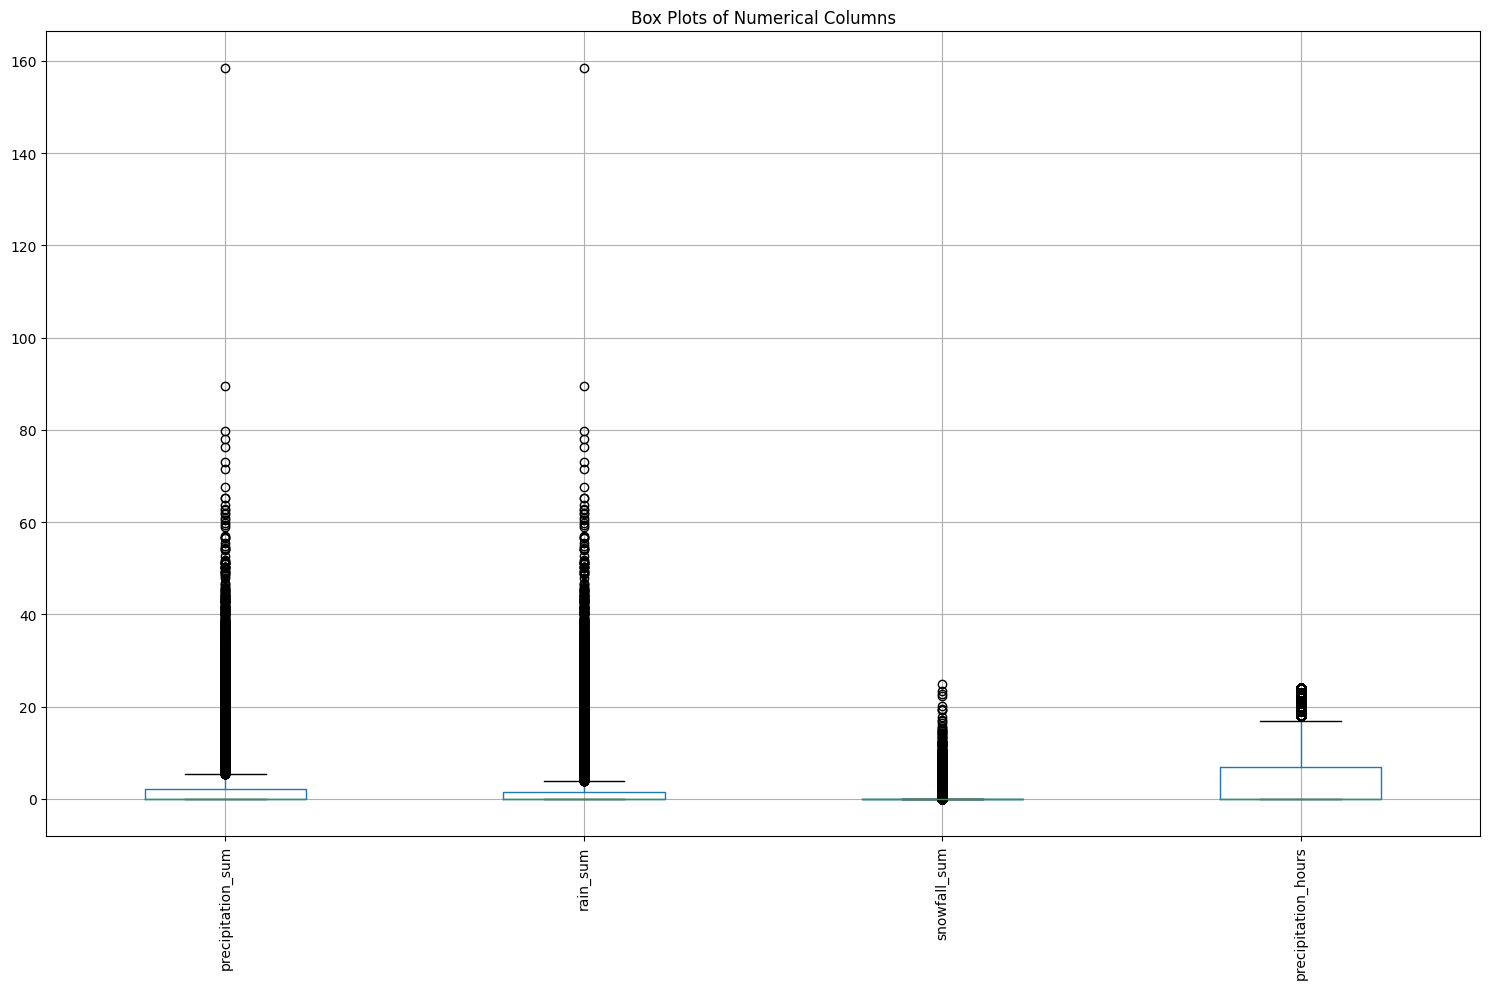

In [23]:
# Create box plots to inspect the top outliers
plt.figure(figsize=(15, 10))
df.boxplot(column=list(outlier_col), figsize=(15, 10))
plt.xticks(rotation=90)
plt.title('Box Plots of Numerical Columns')
plt.tight_layout()
plt.show()

After investagting the dataset for outliers it has become clear that the dataset does have outliers, but these outliers does fall under the expected behavior for weather patterns and in most cases represents extreme weather events, while in other cases the outliers represent weather events that don't occur frequently. For example it snowing in Zurich occurs infrequently.

### Working with missing data

Because the data is to clean and has no missing data, I am going to create missing data and the demonstrate how to deal with missing data, by randomly removing data from the dataset 

In [1]:
df_mis = pd.read_csv("Data/start.csv")

NameError: name 'pd' is not defined

In [ ]:
# Generate 1000 random numbers that represents the rows to apply missing values
random_numbers = [random.randint(1, len(df_mis)) for _ in range(1000)]

In [31]:
# Get a list of all the column names
columns = list(df_mis.columns)

# Remove date and city from the list
columns.remove('date')
columns.remove('city')

In [32]:
# Randomly apply NaN values to the columns and rows
for num in random_numbers:
	for col in columns:
		if random.choice([0, 1]) == 1:
			df_mis.loc[num, col] = np.nan

In [ ]:
# Check the extend of the missing data
print(df_mis.isna().sum())

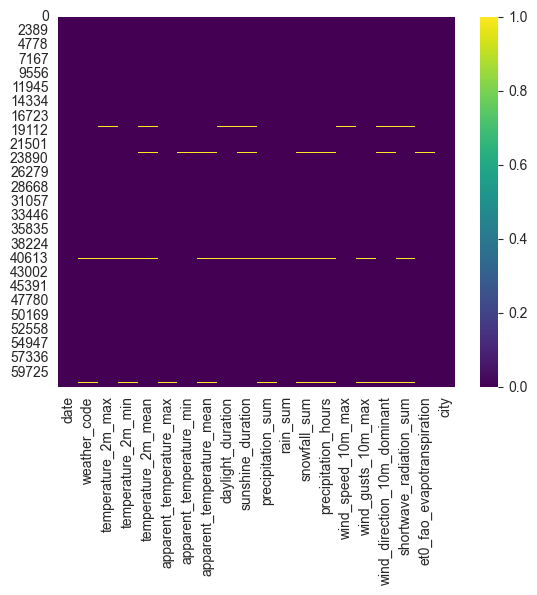

In [34]:
.0# Plot a heat map for missing values
sns.heatmap(df_mis.isnull(), cbar=True, cmap='viridis')
plt.show()

In [35]:
# Fill missing values with interpolation
# Using the linear method as it is the best fit for weather data
df_filled = df_mis[columns].interpolate(method='linear')

In [36]:
# Check if there is still missing values
print(df_filled.isna().sum())

weather_code                   0
temperature_2m_max             0
temperature_2m_min             0
temperature_2m_mean            0
apparent_temperature_max       0
apparent_temperature_min       0
apparent_temperature_mean      0
daylight_duration              0
sunshine_duration              0
precipitation_sum              0
rain_sum                       0
snowfall_sum                   0
precipitation_hours            0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
shortwave_radiation_sum        0
et0_fao_evapotranspiration     0
dtype: int64
